In [40]:
import pytreenet as ptn
import numpy as np
from pytreenet.time_evolution.tdvp_algorithms.TJM import normalize_ttn
from pytreenet.time_evolution.tdvp_algorithms import GSE_TJM_TDVP

# Initial state

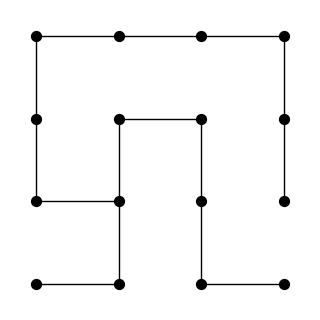

In [41]:
import pickle
# Load the Pickle file
with open('tdvp_profiling_data_3.pkl', 'rb') as f:
    profiling_data = pickle.load(f)

# Extract profiling details from the loaded data
profiling_details = profiling_data['profiling_details']

config_id = 'Config 189'
bond_dim = 4
ttn = profiling_details[config_id]['Spanning_tree']

black_state = np.array([-1+2j , 1j])
white_state = np.array([1 , -2j])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim,  pattern = "checkerboard")
local_tensor = np.array([0 , 1])
ttn = ptn.uniform_product_state(ttn,local_state=local_tensor, bond_dim = bond_dim)


ptn.Visualize_tree(profiling_details[config_id]['tree_dict'],4)

# Hamiltonian and operators

In [42]:
def T(t,Lx, Ly , d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dimension=d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op })
    
    terms = []

    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))

    
    return ptn.Hamiltonian(terms, conversion_dict)


def V(U, Lx, Ly , d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dimension=d)
    
    conversion_dict = {
        "n": number_op,
        f"I{d}": np.eye(d),
        "U * n * (n - 1)": U * number_op 
    }

    terms = []
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)


In [43]:
Lx = 4
Ly = 4
t = 1
U = 0.1
d = 2

H1 = ptn.BoseHubbard_ham(t, U, Lx, Ly , d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

operators = {}
number_op = ptn.bosonic_operators(d)[2]

for node_id in ttn.nodes.keys():
    operators[node_id] = ptn.TensorProduct({node_id: number_op})

N = ptn.Number_op_total(Lx, Ly, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

H1 = T(t, Lx, Ly , d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
T = ptn.TTNO.from_hamiltonian(H1, ttn)

H1 = V(U, Lx, Ly , d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
V = ptn.TTNO.from_hamiltonian(H1, ttn)

operators["T"] = {"T" : T}
operators["V"] = {"V" : V}

operators["E"] = {"E" : ttno}
operators["N"] = {"N" : N}



# Noise model

In [44]:
from pytreenet.time_evolution.tdvp_algorithms.TJM import NoiseModel
# Define the noise model
gamma = 0.1
noise_model = NoiseModel(['relaxation', 'dephasing'], [gamma , gamma])
print(noise_model.processes)
print(noise_model.jump_operators)
print(noise_model.strengths)

['relaxation', 'dephasing']
[array([[0., 1.],
       [0., 0.]]), array([[ 1,  0],
       [ 0, -1]])]
[0.1, 0.1]


# GSE-TJM-TDVP

In [45]:
expaction_params = {"mode" : "Krylov", # "Krylov" or "Taylor"
                    "size_threshold" : 500, # no higher approximation in default
                    # "Krylov" parameters
                    "Krylov_tol"  : 1e-5,
                    "krylov_dim"   : 5,
                    # "Taylor" parameters
                    "Taylor_num_terms"  : 3}
expansion_params = {"ExpansionMode": ptn.ExpansionMode.TTN,
                    "num_vecs": 3, 
                    "tau": 0.01,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-3 , total_tol = -np.inf),
                    "expansion_steps" : 20,
                    "tol": 0.5,
                    "tol_step_increase": 0.08,
                    "tol_step_decrease": 0.03,
                    "num_second_trial" : 10,
                    "max_bond": 200,
                    "rel_tot_bond": (20,40),}

config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   ExpAction_params= expaction_params,
                                   Expansion_params = expansion_params) 

ttn = normalize_ttn(ttn)
tdvp_tjm = GSE_TJM_TDVP(initial_state = ttn,
                        hamiltonian = ttno,
                        time_step_size = 0.1,
                        final_time = 3,
                        operators = operators,
                        N = 20,
                        noise_model = noise_model,
                        config = config)

In [46]:
stop

NameError: name 'stop' is not defined

In [29]:
black_state = np.array([-1+2j , 1j])
white_state = np.array([1 , -2j])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim,  pattern = "checkerboard")
local_tensor = np.array([0 , 1])
ttn = ptn.uniform_product_state(ttn,local_state=local_tensor, bond_dim = bond_dim)
ttn = normalize_ttn(ttn)

In [39]:
operators = {k: v for d in tdvp_tjm.operators for k, v in d.items()}
ptn.expectation_value(ttn ,operators["E"]) , ttn.operator_expectation_value(operators["N"])

((1.6000000000000003+0j), (16+0j))

In [409]:
op = number_op @ (number_op - np.eye(d))
ttn.operator_expectation_value(ptn.TensorProduct({"Site(0,0)": op}))

0j

In [412]:
number_op

array([[0., 0.],
       [0., 1.]])

In [398]:
operators["N"]

In [45]:
tdvp_tjm.run_TJM(evaluation_time = 1)

Time steps:  13%|███▋                        | 134/1020 [00:37<01:49,  8.08it/s]

Initial tol: 0.5


Time steps:  14%|███▊                        | 139/1020 [00:38<01:22, 10.69it/s]

Acceptable expansion found in initial attempt: 25
Final expanded_dim: 25 : 63 ---> 88


Time steps:  14%|███▉                        | 143/1020 [00:38<01:41,  8.65it/s]

Initial tol: 0.5
Initial tol: 0.5


Time steps:  14%|███▉                        | 144/1020 [00:39<01:41,  8.65it/s]

Initial tol: 0.5


Time steps:  14%|███▉                        | 145/1020 [00:39<02:03,  7.07it/s]

Initial tol: 0.5
Phase 2 - Trial 1:
Decreasing tol: 0.47


Time steps:  14%|████                        | 147/1020 [00:39<02:15,  6.44it/s]

Initial tol: 0.5
Initial tol: 0.5


Time steps:  14%|████                        | 147/1020 [00:39<02:15,  6.44it/s]

Acceptable expansion found in initial attempt: 26
Final expanded_dim: 26 : 63 ---> 89
Expanded_dim_tot: -29
Phase 2 - Trial 2:
Decreasing tol: 0.43999999999999995


Time steps:  15%|████                        | 148/1020 [00:40<03:30,  4.15it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 63 ---> 84


Time steps:  15%|████                        | 148/1020 [00:40<03:30,  4.15it/s]

Expanded_dim_tot: -21
Phase 2 - Trial 3:
Decreasing tol: 0.4099999999999999


Time steps:  15%|████                        | 148/1020 [00:41<03:30,  4.15it/s]

Acceptable expansion found in initial attempt: 23
Final expanded_dim: 23 : 63 ---> 86
Acceptable expansion found in initial attempt: 23
Final expanded_dim: 23 : 63 ---> 86


Time steps:  15%|████                        | 148/1020 [00:41<03:30,  4.15it/s]

Expanded_dim_tot: -23
Phase 2 - Trial 4:
Decreasing tol: 0.3799999999999999
Acceptable expansion found in initial attempt: 29
Final expanded_dim: 29 : 63 ---> 92


Time steps:  15%|████                        | 149/1020 [00:41<06:00,  2.41it/s]

Expanded_dim_tot: -27
Phase 2 - Trial 5:
Decreasing tol: 0.34999999999999987


Time steps:  15%|████▏                       | 151/1020 [00:42<05:04,  2.86it/s]

Expanded_dim_tot: -23
Phase 2 - Trial 6:
Decreasing tol: 0.31999999999999984


Time steps:  15%|████▏                       | 154/1020 [00:42<03:42,  3.89it/s]

Expanded_dim_tot: -18
Phase 2 - Trial 7:
Decreasing tol: 0.2899999999999998


Time steps:  15%|████▎                       | 155/1020 [00:43<03:14,  4.45it/s]

Expanded_dim_tot: -19
Phase 2 - Trial 8:
Decreasing tol: 0.2599999999999998


Time steps:  15%|████▎                       | 157/1020 [00:43<04:26,  3.24it/s]

Expanded_dim_tot: -23
Phase 2 - Trial 9:
Decreasing tol: 0.2299999999999998


Time steps:  16%|████▎                       | 159/1020 [00:44<03:41,  3.89it/s]

Expanded_dim_tot: -15
Phase 2 - Trial 10:
Decreasing tol: 0.1999999999999998


Time steps:  16%|████▍                       | 161/1020 [00:45<04:46,  3.00it/s]

Expanded_dim_tot: -27
Exceeded maximum trials in Phase 2 without acceptable expansion
Final expanded_dim: 0 : 63 ---> 63


Time steps:  25%|██████▉                     | 254/1020 [01:00<02:52,  4.44it/s]

Initial tol: 0.1699999999999998


Time steps:  25%|███████▏                    | 260/1020 [01:01<02:38,  4.81it/s]

Acceptable expansion found in initial attempt: 28
Final expanded_dim: 28 : 63 ---> 91


Time steps:  28%|███████▋                    | 281/1020 [01:04<01:40,  7.36it/s]

Initial tol: 0.5
Initial tol: 0.5


Time steps:  28%|███████▊                    | 283/1020 [01:05<01:38,  7.46it/s]

Initial tol: 0.5


Time steps:  28%|███████▊                    | 284/1020 [01:05<02:29,  4.92it/s]

Acceptable expansion found in initial attempt: 24
Final expanded_dim: 24 : 82 ---> 106


Time steps:  28%|███████▉                    | 287/1020 [01:06<02:36,  4.70it/s]

Initial tol: 0.5
Acceptable expansion found in initial attempt: 24
Final expanded_dim: 24 : 84 ---> 108
Initial tol: 0.5


Time steps:  28%|███████▉                    | 288/1020 [01:06<03:26,  3.54it/s]

Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 82 ---> 109


Time steps:  29%|████████                    | 292/1020 [01:08<04:48,  2.52it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 84 ---> 105


Time steps:  29%|████████                    | 294/1020 [01:09<03:42,  3.27it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 85 ---> 106


Time steps:  29%|████████▏                   | 300/1020 [01:10<04:13,  2.84it/s]

Initial tol: 0.5


Time steps:  30%|████████▌                   | 311/1020 [01:13<02:53,  4.09it/s]

Acceptable expansion found in initial attempt: 28
Final expanded_dim: 28 : 89 ---> 117


Time steps:  41%|███████████▌                | 421/1020 [01:30<01:06,  9.05it/s]

Initial tol: 0.5


Time steps:  42%|███████████▋                | 427/1020 [01:31<01:10,  8.35it/s]

Acceptable expansion found in initial attempt: 26
Final expanded_dim: 26 : 63 ---> 89


Time steps:  47%|█████████████▎              | 484/1020 [01:36<00:51, 10.51it/s]

Initial tol: 0.5


Time steps:  48%|█████████████▎              | 487/1020 [01:37<00:48, 10.94it/s]

Initial tol: 0.5
Acceptable expansion found in initial attempt: 24
Final expanded_dim: 24 : 63 ---> 87


Time steps:  48%|█████████████▍              | 490/1020 [01:37<00:59,  8.97it/s]

Initial tol: 0.5
Acceptable expansion found in initial attempt: 24
Final expanded_dim: 24 : 63 ---> 87


Time steps:  49%|█████████████▌              | 495/1020 [01:38<01:03,  8.25it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 63 ---> 84


Time steps:  50%|█████████████▊              | 505/1020 [01:39<00:47, 10.86it/s]

Initial tol: 0.5


Time steps:  50%|██████████████              | 512/1020 [01:40<00:57,  8.85it/s]

Phase 2 - Trial 1:
Decreasing tol: 0.47
Initial tol: 0.5


Time steps:  50%|██████████████▏             | 515/1020 [01:40<01:13,  6.87it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 63 ---> 84
Expanded_dim_tot: -24
Phase 2 - Trial 2:
Decreasing tol: 0.43999999999999995


Time steps:  51%|██████████████▏             | 519/1020 [01:41<01:27,  5.72it/s]

Expanded_dim_tot: -29
Phase 2 - Trial 3:
Decreasing tol: 0.4099999999999999


Time steps:  51%|██████████████▍             | 524/1020 [01:42<01:13,  6.73it/s]

Expanded_dim_tot: -30
Phase 2 - Trial 4:
Decreasing tol: 0.3799999999999999


Time steps:  52%|██████████████▍             | 528/1020 [01:42<01:12,  6.78it/s]

Expanded_dim_tot: -32
Phase 2 - Trial 5:
Decreasing tol: 0.34999999999999987


Time steps:  52%|██████████████▌             | 531/1020 [01:43<01:22,  5.89it/s]

Expanded_dim_tot: -29
Phase 2 - Trial 6:
Decreasing tol: 0.31999999999999984


Time steps:  53%|██████████████▋             | 537/1020 [01:44<01:03,  7.66it/s]

Expanded_dim_tot: -30
Phase 2 - Trial 7:
Decreasing tol: 0.2899999999999998


Time steps:  53%|██████████████▊             | 541/1020 [01:45<01:34,  5.04it/s]

Expanded_dim_tot: -28
Phase 2 - Trial 8:
Decreasing tol: 0.2599999999999998


Time steps:  53%|██████████████▉             | 545/1020 [01:45<01:11,  6.67it/s]

Expanded_dim_tot: -27
Phase 2 - Trial 9:
Decreasing tol: 0.2299999999999998


Time steps:  54%|███████████████             | 548/1020 [01:46<01:26,  5.45it/s]

Expanded_dim_tot: -26
Phase 2 - Trial 10:
Decreasing tol: 0.1999999999999998


Time steps:  54%|███████████████▏            | 552/1020 [01:46<01:14,  6.27it/s]

Initial tol: 0.5


Time steps:  54%|███████████████▏            | 553/1020 [01:46<01:14,  6.27it/s]

Expanded_dim_tot: -29
Exceeded maximum trials in Phase 2 without acceptable expansion
Final expanded_dim: 0 : 63 ---> 63


Time steps:  54%|███████████████▏            | 555/1020 [01:47<01:20,  5.75it/s]

Acceptable expansion found in initial attempt: 26
Final expanded_dim: 26 : 63 ---> 89


Time steps:  58%|████████████████            | 587/1020 [01:51<00:51,  8.37it/s]

Initial tol: 0.5


Time steps:  59%|████████████████▍           | 598/1020 [01:53<00:58,  7.18it/s]

Acceptable expansion found in initial attempt: 31
Final expanded_dim: 31 : 86 ---> 117


Time steps:  61%|████████████████▉           | 618/1020 [01:56<01:00,  6.64it/s]

Initial tol: 0.5


Time steps:  61%|█████████████████           | 622/1020 [01:56<00:57,  6.98it/s]

Initial tol: 0.5
Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 80 ---> 101


Time steps:  61%|█████████████████▏          | 627/1020 [01:57<00:50,  7.81it/s]

Acceptable expansion found in initial attempt: 30
Final expanded_dim: 30 : 81 ---> 111


Time steps:  62%|█████████████████▍          | 633/1020 [01:58<01:08,  5.64it/s]

Initial tol: 0.5


Time steps:  63%|█████████████████▌          | 642/1020 [02:00<01:10,  5.34it/s]

Initial tol: 0.5


Time steps:  63%|█████████████████▋          | 644/1020 [02:00<00:52,  7.11it/s]

Acceptable expansion found in initial attempt: 30
Final expanded_dim: 30 : 85 ---> 115


Time steps:  63%|█████████████████▋          | 646/1020 [02:01<01:21,  4.61it/s]

Initial tol: 0.1699999999999998


Time steps:  64%|█████████████████▊          | 649/1020 [02:01<01:31,  4.03it/s]

Acceptable expansion found in initial attempt: 21
Final expanded_dim: 21 : 80 ---> 101


Time steps:  64%|█████████████████▊          | 649/1020 [02:02<01:31,  4.03it/s]

Acceptable expansion found in initial attempt: 40
Final expanded_dim: 40 : 63 ---> 103


Time steps:  66%|██████████████████▌         | 676/1020 [02:08<01:12,  4.75it/s]

Initial tol: 0.5


Time steps:  67%|██████████████████▋         | 682/1020 [02:09<01:24,  3.99it/s]

Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 84 ---> 111


Time steps:  79%|██████████████████████      | 802/1020 [02:23<00:19, 11.00it/s]

Initial tol: 0.5


Time steps:  79%|██████████████████████▏     | 808/1020 [02:24<00:19, 10.77it/s]

Acceptable expansion found in initial attempt: 23
Final expanded_dim: 23 : 63 ---> 86


Time steps:  81%|██████████████████████▌     | 824/1020 [02:26<00:17, 11.08it/s]

Initial tol: 0.5
Initial tol: 0.5


Time steps:  81%|██████████████████████▋     | 827/1020 [02:26<00:17, 10.90it/s]

Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 63 ---> 90
Acceptable expansion found in initial attempt: 22
Final expanded_dim: 22 : 63 ---> 85


Time steps:  81%|██████████████████████▊     | 830/1020 [02:26<00:20,  9.16it/s]

Initial tol: 0.5


Time steps:  82%|██████████████████████▉     | 834/1020 [02:27<00:24,  7.64it/s]

Acceptable expansion found in initial attempt: 26
Final expanded_dim: 26 : 63 ---> 89


Time steps:  83%|███████████████████████▏    | 846/1020 [02:28<00:18,  9.45it/s]

Initial tol: 0.5


Time steps:  83%|███████████████████████▎    | 848/1020 [02:29<00:26,  6.46it/s]

Acceptable expansion found in initial attempt: 22
Final expanded_dim: 22 : 63 ---> 85


Time steps:  86%|███████████████████████▉    | 873/1020 [02:32<00:18,  7.90it/s]

Initial tol: 0.5


Time steps:  86%|████████████████████████    | 876/1020 [02:33<00:25,  5.54it/s]

Acceptable expansion found in initial attempt: 24
Final expanded_dim: 24 : 63 ---> 87


Time steps:  91%|█████████████████████████▌  | 931/1020 [02:41<00:12,  7.37it/s]

Initial tol: 0.5


Time steps:  92%|█████████████████████████▋  | 938/1020 [02:43<00:19,  4.31it/s]

Acceptable expansion found in initial attempt: 29
Final expanded_dim: 29 : 80 ---> 109


Time steps:  92%|█████████████████████████▉  | 943/1020 [02:44<00:16,  4.80it/s]

Initial tol: 0.5


Time steps:  93%|██████████████████████████  | 948/1020 [02:46<00:16,  4.49it/s]

Acceptable expansion found in initial attempt: 29
Final expanded_dim: 29 : 80 ---> 109


Time steps:  93%|██████████████████████████▏ | 952/1020 [02:47<00:14,  4.59it/s]

Initial tol: 0.5


Time steps:  94%|██████████████████████████▏ | 954/1020 [02:48<00:17,  3.87it/s]

Initial tol: 0.5


Time steps:  94%|██████████████████████████▏ | 956/1020 [02:48<00:17,  3.69it/s]

Initial tol: 0.5


Time steps:  94%|██████████████████████████▎ | 957/1020 [02:49<00:13,  4.62it/s]

Acceptable expansion found in initial attempt: 27
Final expanded_dim: 27 : 86 ---> 113


Time steps:  94%|██████████████████████████▎ | 959/1020 [02:50<00:18,  3.28it/s]

Acceptable expansion found in initial attempt: 30
Final expanded_dim: 30 : 82 ---> 112


Time steps:  94%|██████████████████████████▍ | 962/1020 [02:51<00:21,  2.64it/s]

Acceptable expansion found in initial attempt: 32
Final expanded_dim: 32 : 86 ---> 118


Time steps:  96%|██████████████████████████▊ | 979/1020 [02:56<00:08,  4.66it/s]

Initial tol: 0.5


Time steps:  96%|███████████████████████████ | 984/1020 [02:58<00:10,  3.55it/s]

Acceptable expansion found in initial attempt: 32
Final expanded_dim: 32 : 83 ---> 115


Time steps: 100%|███████████████████████████| 1020/1020 [03:11<00:00,  5.32it/s]


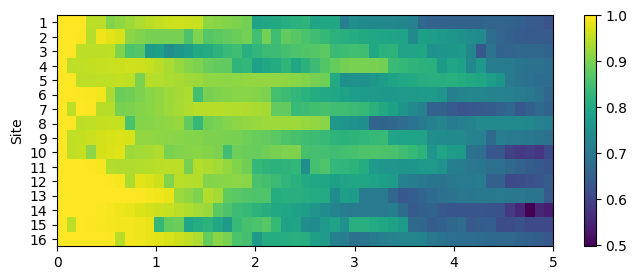

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming tdvp_tjm.results is a dictionary with numerical arrays:
heatmap = np.array(list(tdvp_tjm.results.values()))[:-4,:]
vmin = np.min(heatmap)
vmax = np.max(heatmap)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
L = len(tdvp_tjm.state.nodes.keys())
im = ax.imshow(heatmap, aspect='auto', extent=[0, tdvp_tjm.final_time, L, 0],
                  cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_ylabel('Site')

# Centers site ticks
ax.set_yticks(np.arange(0, L) + 0.5)
ax.set_yticklabels(np.arange(1, L+1))

fig.colorbar(im, ax=ax)
plt.show()

In [19]:
tdvp_tjm.operators

[{'Site(0,2)': array([[0., 0.],
        [0., 1.]])},
 {'Site(0,1)': array([[0., 0.],
        [0., 1.]])},
 {'Site(0,0)': array([[0., 0.],
        [0., 1.]])},
 {'Site(1,0)': array([[0., 0.],
        [0., 1.]])},
 {'Site(2,0)': array([[0., 0.],
        [0., 1.]])},
 {'Site(2,1)': array([[0., 0.],
        [0., 1.]])},
 {'Site(3,1)': array([[0., 0.],
        [0., 1.]])},
 {'Site(3,0)': array([[0., 0.],
        [0., 1.]])},
 {'Site(1,1)': array([[0., 0.],
        [0., 1.]])},
 {'Site(1,2)': array([[0., 0.],
        [0., 1.]])},
 {'Site(2,2)': array([[0., 0.],
        [0., 1.]])},
 {'Site(3,2)': array([[0., 0.],
        [0., 1.]])},
 {'Site(3,3)': array([[0., 0.],
        [0., 1.]])},
 {'Site(0,3)': array([[0., 0.],
        [0., 1.]])},
 {'Site(1,3)': array([[0., 0.],
        [0., 1.]])},
 {'Site(2,3)': array([[0., 0.],
        [0., 1.]])},
 {'E': <pytreenet.ttno.ttno_class.TreeTensorNetworkOperator at 0x1ce61d7ff50>},
 {'N': <pytreenet.ttno.ttno_class.TreeTensorNetworkOperator at 0x1ce6516

In [356]:
tdvp_tjm.results['V']

array([1.6       , 1.6       , 1.58      , 1.57      , 1.54999995,
       1.5449998 , 1.53499696, 1.52999951, 1.5199981 , 1.49499712,
       1.46999631, 1.45499393, 1.43998945, 1.41498622, 1.3999841 ,
       1.38499388, 1.38496038, 1.36995034, 1.36493743, 1.34495157,
       1.33992111, 1.31985989, 1.31483409, 1.30480427, 1.29477294,
       1.29972878, 1.28969888, 1.26968535, 1.25464651, 1.24984593,
       1.22478963, 1.21983298, 1.20475386, 1.18978427, 1.18466881,
       1.17474479, 1.15981839, 1.14515939, 1.12470434, 1.1293856 ,
       1.12414695, 1.13389233, 1.10877874, 1.09885882, 1.09363578,
       1.07459542, 1.0787767 , 1.05846378, 1.0485255 , 1.0430697 ,
       1.03796712])

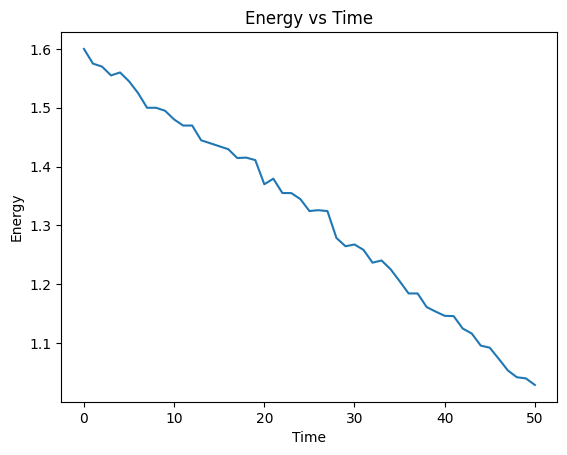

In [ ]:
tdvp_tjm.results.values()
plt.plot(tdvp_tjm.results['E'])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time')
plt.show()